In [2]:
from astropy.io import fits
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans
import scipy
from astroquery.gaia import Gaia
import os

In [3]:
def read_hsc_fits(file_path):
    # Read in the fits file and close it
    hdul = fits.open(file_path)
    data = hdul[1].data
    hdul.close()

    # Print the column names and length of the data
    # print(data.columns.names)
    # print(len(data))

    # Get object IDs, parent IDs, ira, idec and imagnitudes and add to pandas dataframe
    hsc_y1 = pd.DataFrame({'object_id': data['object_id'], 'parent_id': data['parent_id'], 'ra': data['ira'], 'dec': data['idec'], 'imag': data['imag_psf']})

    # Combine ra and dec into a sky coord array
    hsc_y1['coord'] = SkyCoord(ra=hsc_y1['ra'], dec=hsc_y1['dec'], unit = 'deg')
    return hsc_y1

# Cycle through fits files in data directory and read in the data, and stack it into a single dataframe
hsc_full = pd.DataFrame()
for i in os.listdir('../data'):
    if 'stars.fits' in i:
        file_path = '../data/' + i
        hsc_y1 = read_hsc_fits(file_path)
        print('File read in: ' + i)
        hsc_full = pd.concat([hsc_full, hsc_y1], ignore_index=True)
        


File read in: XMM_stars.fits
File read in: HECTOMAP_stars.fits
File read in: GAMA09H_stars.fits
File read in: VVDS_stars.fits
File read in: WIDE12H_stars.fits
File read in: GAMA15H_stars.fits


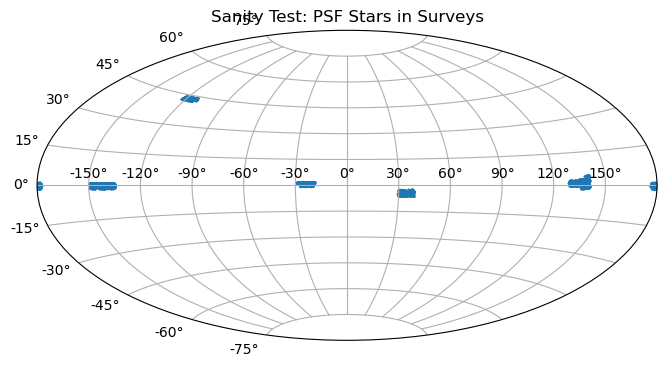

In [14]:
# Function to plot the ra and dec of the PSF stars
def plot_sanity_test(coord, n = 10000):
    plt.figure(figsize=(8,4.2))
    plt.subplot(111, projection="aitoff")
    plt.title("Sanity Test: PSF Stars in Surveys")
    plt.grid(True)
    
    # Choose n random stars
    coord = coord.sample(n=n)
    
    ra_rad = np.array([c.ra.wrap_at(180 * u.deg).radian for c in coord])
    dec_rad = np.array([c.dec.radian for c in coord])
    plt.scatter(ra_rad, dec_rad, s=0.1, alpha=0.8)
    plt.show()
    
# Plot the ra and dec of the PSF stars
plot_sanity_test(hsc_full['coord'])


In [4]:
# Get 2D array of ra and dec from dataframe
ra_dec = np.array([hsc_full['ra'], hsc_full['dec']]).T

# Perform clustering
number_of_clusters = 10
cents = kmeans(ra_dec, number_of_clusters)
centroids = cents[0]
cluster_num_array = vq(ra_dec, centroids)

# Generate cluster info df
max_dist_pts = {i:[np.array([k for k in cluster_num_array[1][cluster_num_array[0] == i]]).max()] for i in range(number_of_clusters)}
cluster_info = pd.DataFrame(max_dist_pts).T
cluster_info.columns = ["max_dist"]
cluster_info["clusterno"] = cluster_info.index
cluster_info["dists"] = [cluster_num_array[1][cluster_num_array[0] == i] for i in cluster_info["clusterno"]]
cluster_info["centroids"] = list(centroids)

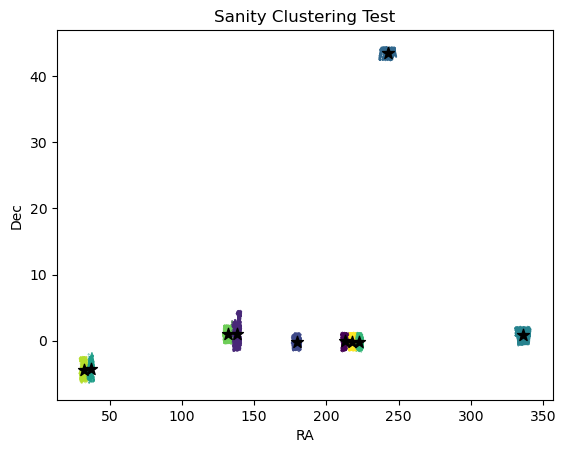

In [11]:
# Sanity check: plot clustering result
def plot_cluster_test(ra_dec, centroids, cluster_num_array):
    
    # Sample 10000 random 2D points from numpy array
    idx = np.random.choice(ra_dec.shape[0], 10000, replace=False)
    rds = ra_dec[idx, :]
    
    # scatter plot of K-Means cluster
    plt.scatter(rds[:, 0],
                rds[:, 1],
                c=cluster_num_array[0][idx], s  = 0.1)
    
    # Centroid of the clusters
    plt.scatter(centroids[:, 0],
                centroids[:, 1],
                marker='*',
                s=80,
                color='black')

    plt.title("Sanity Clustering Test")
    plt.xlabel("RA")
    plt.ylabel("Dec")
    
# plot cluster test
plot_cluster_test(ra_dec, cents[0], cluster_num_array)

In [12]:
def query_gaia_for_cluster(ra, dec, dist):
    # Define the center coordinates of your region and the search radius
    center_coordinates = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
    search_radius = dist * u.deg  # Adjust the radius as needed
    
    Gaia.ROW_LIMIT = -1
    job = Gaia.cone_search_async(center_coordinates, radius=search_radius, columns=["ra", "dec"])
    result_table = job.get_results()
    gaia_table = result_table.to_pandas()
    
    return gaia_table

In [ ]:
def match_cluster_to_gaia(cluster_num_array, ra_dec, cluster_info, cluster_num):
    """
    Match stars in cluster 'cluster_num' to gaia stars. Create a table with gaia coords, cluster coords, and flag for matched stars.
    """
    
    # Query gaia and match stars to cluster
    clust0_info = cluster_info.loc[cluster_num]
    gaia0_tab = query_gaia_for_cluster(clust0_info["centroids"][0], clust0_info["centroids"][1], clust0_info["max_dist"])
    cluster0 = SkyCoord(ra_dec[cluster_num_array[0] == cluster_num] * u.deg)
    mag0 = np.array(hsc_full['imag'][cluster_num_array[0] == cluster_num])
    gaia0 = SkyCoord(ra = gaia0_tab['ra'], dec = gaia0_tab['dec'], unit=u.deg)
    idx_clust, sep2d_clust, _ = cluster0.match_to_catalog_sky(gaia0)
    
    # Create table with gaia0 coords, cluster0 coords, and flag for matched stars
    comb_stars = pd.DataFrame({'matched': np.zeros(len(cluster0))})
    comb_stars.loc[sep2d_clust < 1 * u.arcsec] = 1
    comb_stars['gaia0'] = gaia0[idx_clust]
    comb_stars['cluster0'] = cluster0
    comb_stars['sep2d'] = sep2d_clust.arcsec # in arcsec
    comb_stars['mag0'] = mag0

    get_ra = lambda x: x.ra.degree
    get_dec = lambda x: x.dec.degree

    comb_stars["gaia_ra"] = comb_stars["gaia0"].apply(get_ra)
    comb_stars["gaia_dec"] = comb_stars["gaia0"].apply(get_dec)
    comb_stars["cluster_ra"] = comb_stars["cluster0"].apply(get_ra)
    comb_stars["cluster_dec"] = comb_stars["cluster0"].apply(get_dec)
    
    return comb_stars

In [16]:
# Combine pandas dataframes from all clusters
master_comb_df = pd.DataFrame()
for i in range(number_of_clusters):
    print("Matching cluster " + str(i) + " to Gaia...")
    comb_clusteri = match_cluster_to_gaia(cluster_num_array, ra_dec, cluster_info, i)
    master_comb_df = pd.concat([master_comb_df, comb_clusteri])

Matching cluster 0 to Gaia...
INFO: Query finished. [astroquery.utils.tap.core]


IndexError: Boolean index has wrong length: 922355 instead of 263484

Text(0.5, 1.0, 'Matched Stars: Separation in Arcsec')

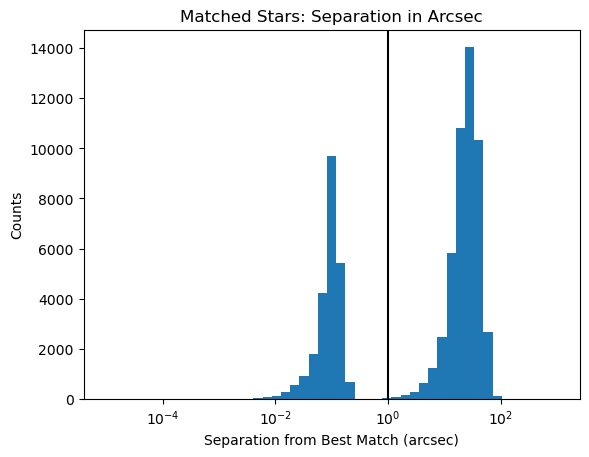

In [ ]:
plt.hist(master_comb_df["sep2d"], bins = np.logspace(-5, 3))
plt.semilogx()
plt.axvline(1, color = "k")
plt.ylabel("Counts")
plt.xlabel("Separation from Best Match (arcsec)")
plt.title("Matched Stars: Separation in Arcsec")

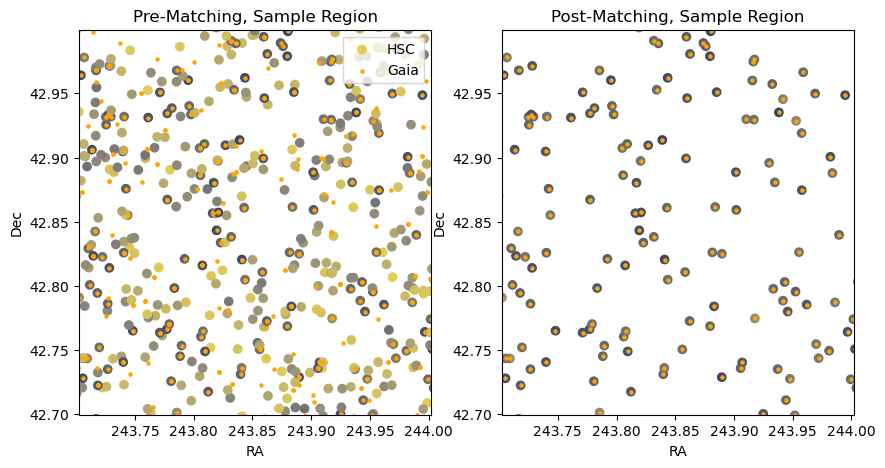

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))


# Scatter plot for the first subplot
ax[0].scatter(master_comb_df["cluster_ra"], master_comb_df["cluster_dec"], c = master_comb_df["mag0"], cmap = "cividis", 
              vmin = 18, vmax = 23, label = "HSC")
ax[0].scatter(master_comb_df["gaia_ra"], master_comb_df["gaia_dec"], s=5, color="orange", label = "Gaia")
ax[0].legend(loc = 'upper right')

# Set labels and limits for the first subplot
ax[0].set_xlabel("RA")
ax[0].set_ylabel("Dec")
ax[0].set_xlim(centroids[0][0] - 0.15, centroids[0][0] + 0.15)
ax[0].set_ylim(centroids[0][1] - 0.15, centroids[0][1] + 0.15)

ax[0].set_title("Pre-Matching, Sample Region")

# Scatter plot for the second subplot
match_idx = (master_comb_df["matched"] == 1)
ax[1].scatter(master_comb_df["cluster_ra"][match_idx], master_comb_df["cluster_dec"][match_idx], c = master_comb_df["mag0"][match_idx], cmap = "cividis",
              vmin = 18, vmax = 23)
ax[1].scatter(master_comb_df["gaia_ra"][match_idx], master_comb_df["gaia_dec"][match_idx], s=5, color="orange")

# Set labels and limits for the second subplot
ax[1].set_xlabel("RA")
ax[1].set_ylabel("Dec")
ax[1].set_xlim(centroids[0][0] - 0.15, centroids[0][0] + 0.15)
ax[1].set_ylim(centroids[0][1] - 0.15, centroids[0][1] + 0.15)

ax[1].set_title("Post-Matching, Sample Region")

# Show the plots
plt.show()

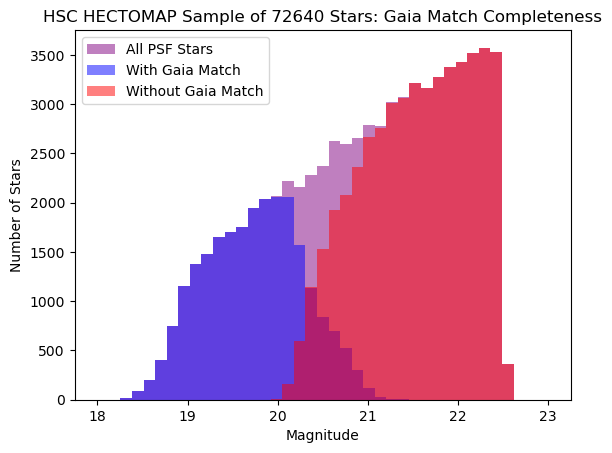

In [ ]:
plt.hist(master_comb_df["mag0"], bins = np.linspace(18, 23, 40), label = "All PSF Stars", alpha = 0.5, color = "purple")
plt.hist(master_comb_df["mag0"][match_idx],bins = np.linspace(18, 23, 40), label = "With Gaia Match", alpha = 0.5, color = "blue")
plt.hist(master_comb_df["mag0"][~match_idx], bins = np.linspace(18, 23, 40), label = "Without Gaia Match", alpha = 0.5, color = "red")
plt.title(f"HSC HECTOMAP Sample of {len(master_comb_df)} Stars: Gaia Match Completeness")
plt.xlabel("Magnitude")
plt.ylabel("Number of Stars")
plt.legend()